<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 4 - Spin-boson model

Throughout the first 3 tutorials, we have gradually come to see that a two state system (hereafter abbreviated to `TSS`) interacting with its environment can be modelled as a spin 1/2 particle in a magnetic field interacting with a quantised field of bosons.

In this tutorial we explore this `spin-boson` model (as it is often called) in more detail and in so doing we'll (as always) discover some new physics along the way 🤓. It is worth noting that the spin-boson model also goes by other names - most notably the ["dressed atom"](https://youtu.be/k0X7iSaPM38) model which forms parts of various [university courses](https://ocw.mit.edu/courses/physics/8-422-atomic-and-optical-physics-ii-spring-2013/syllabus/).

This tutorial is split up into the following sections:
1. Recap
2. Stationary states
3. Structure of the Hamiltonian
4. Parity
5. Down conversion

In [1]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import gif
import numpy as np
import pandas as pd
from qutip import *
import warnings
warnings.filterwarnings('ignore')
from itertools import product
import os

## 4.1 - Recap

Let's remind ourselves of the Hamiltonian that we built up in the last tutorial ([Tutorial 3](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb#3.6---Spontaneous-emission)):

$$H =  \overbrace{A \sigma_z}^{TSS}+ \overbrace{\hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right)}^{bosons} + \overbrace{\frac{\delta}{2}\left( a^{\dagger} + a \right)\sigma_x}^{interaction}$$

The labels A and $\delta$ were chosen because of the path of discovery that we took to get here. From now on, it will be convenient for us to re-write the Hamiltonian with different labels as:

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)\sigma_x$$

where we recognise $\Delta E$ as the transition energy of the TSS, $\hbar\omega$ the energy of a single boson and $U$ as the strength of the interaction of the TSS with the boson field.

We will be referring to this Hamiltonian many times in our figures so let's make a variable so it's easier to refer to later.

In [2]:
H_latex = "$H = (\Delta E / 2) \sigma_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )\sigma_x$"

In the last tutorial we saw how the physics of spontaneous emission arose from an indirect coupling between the |+> and |-> states of the TSS which was mediated by the interaction with the boson field. This interaction manifested as a Rabi type oscillation between two states of the combined spin boson system (described by |n,±>), namely |0,+> and |1,->.

In general, the result of such interactions are far more complicated than the Rabi type oscillations we are becoming familiar with. The complexity arises because the combined TSS and field system has many states that interact with each other strongly if their energies are similar.

We can however still apply the ideas we've learnt about TSS's in some special and interesting situations. That is what we'll explore in this notebook.

## 4.2 - Stationary states

We begin in the same way that we started this tutorial series ([Tutorial 1](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/01-an-isolated-two-state-system.ipynb#1.1---Stationary-state)) by looking for the stationary states of the system. When the system is in one of these states it will remain there for all time. Such states are described by a single constant energy.

To find the states of constant energy, we'll follow what we did in [Tutorial 2](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#2.1-Static-perturbation). Specifically, we will calculate the eigenvalues of the Hamiltonian (i.e the energies) and see how they depend on the TSS transition energy $\Delta E$.

What do we expect to find? Let's recall Tutorial 2 - the states of the TSS were directly coupled, mimicking the effect of a classical field. In Fig 3 of that tutorial we discovered an [avoided crossing](https://en.wikipedia.org/wiki/Avoided_crossing) (aka anti-crossing) when the transition energy of the TSS was zero  - this was due to the coupling between the states splitting the energy levels apart.

In the more complicated spin-boson system of this tutorial, the states of the TSS can only couple indirectly through the boson field. Let's see whether we find any similarities - we'll start with no interaction $U=0$ to familiarsie ourselves with the landscape before exploring the full delights of the spin boson system.

Since we will be creating many Hamiltonians with differing parameters, it's helpful to create a function to pre-compute the constant pieces. Specifically, the following function `make_operators` will compute the following:

- `two_state` = $\frac{1}{2}\sigma_z$ 
- `bosons` = $a^{\dagger}a +\frac{1}{2}$
- `interaction` = $\left( a^{\dagger} + a \right)\sigma_x$

so that we can create Hamiltonians with many different TSS transition energies $\Delta E$, boson frequencies $\omega$  and interaction strengths $U$ in the following way:

`H = DeltaE*two_state + omega*bosons + U*interaction`

In [2]:
def make_operators(max_bosons):
    
    a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
    sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
    sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator
    
    two_state     =  1/2*sz                         # two state system energy operator   𝜎𝑧/2
    bosons       =  (a.dag()*a+0.5)                 # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                       # boson number operator              𝑎†𝑎
    interaction  = (a.dag() + a) * sx               # interaction energy operator        (𝑎†+𝑎)𝜎𝑥

    
    return two_state, bosons, interaction, number

If we want to be 100% correct in our description of the spin-boson system, we should allow the possibility of an infinite number of bosons to be present. This is obviously not computationally feasible so we must choose a finite number for the maximum number of bosons we wish to consider.

For the sake of simplicity in visualisaion outputs, we choose a small number `max_bosons=4`.

In [3]:
max_bosons = 4
two_state, bosons, interaction, number = make_operators(max_bosons)

We now need to prepare a suitable data structure to hold the data about the energies of the stationary states. A [pandas dataframe](https://www.geeksforgeeks.org/python-pandas-dataframe/) (essentially a table) is a suitable choice (which makes plotting easier later).

We need to specify:
- number of rows - equal to the number of TSS transition energies ($\Delta E$) that we wish to try
- number of columns - equal to the number of energy levels plus 1 to store the values of $\Delta E$
- column labels

Let's create another function for this and then look at an example:

In [5]:
def make_df_for_energy_scan(label_param, min_param, max_param, num_param, num_levels):
    
    # creates an empty dictionary to store the row/column information
    d = {}
    
    # creates array of parameter values that we want to scan through
    param_values = np.linspace(min_param, max_param, num_param)
    
    # stores the parameter scan label and values (this will soon become the first column in the dataframe)
    d[label_param] = param_values
    
    # creates empty columns to store the eigenvalues for the different levels later on
    # num_levels will be the number of rows of H (or any of the operators that make up H)
    for i in range(num_levels):
        d[f"level_{i}"] = np.zeros(num_param)
     
    # creates the dataframe
    df = pd.DataFrame(data=d)
    
    return df

In [6]:
df = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state.shape[0])
df.head()

,$\Delta E$,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9
0,-4.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-3.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We see that we expect to calculate eigenvalues for 10 levels - these are associated with the 2 states from the TSS (|+>, |->) and 5 bosons states ($n= 0,1,2,3,4$) making $2\times5 = 10$ levels.

### 4.2.1 - Spin-boson landscape $U=0$

We're now ready to fill in the dataframe with the energy of the stationary sates by iterating over the rows using the [`iterrows`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) function.

Throughout this tutorial we will set $\omega=1$.

In [7]:
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

Because we stored the data in a dataframe, plotting is now easy.

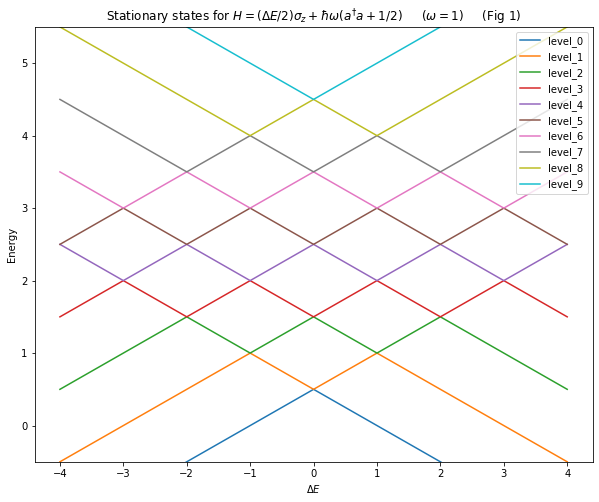

In [8]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=True, 
        title="Stationary states for $H = (\Delta E / 2) \sigma_z + \hbar\omega(a^{{\dagger}}a +1/2)$     ($\omega=1$)     (Fig 1)");
plt.ylabel("Energy");

How do we understand Fig 1 (often called an energy level diagram)?

Start by focusing on where $\Delta E = 0$, i.e. there is no difference between the energies of the |+> and |-> states - this is the first thing we looked at back in Tutorial 1. There are several states/levels that appear to cross each other, they correspond to:
- orange/blue - 0 bosons (|0,±>)
- red/green - 1 boson (|1,±>)
- brown/purple - 2 bosons (|2,±>)
- grey/pink - 3 bosons (|3,±>)
- blue/yellow - 4 bosons (|4,±>)

Let's take the orange (|0,+>) and green (|1,->) lines. As we increase $\Delta E$, The energy of |0,+> goes up  and |1,-> goes down. Eventually, these levels end up with the same energy (they cross) despite having a different number of bosons - this is what allows the |0,+> to couple strongly to |1,-> i.e. it's what makes possible the spontaneous emission we saw in the last tutorial. 

What's particularly interesting is the location of the crossings. For example, the crossing we just described happens when $\Delta E = \omega = 1$. This is physically significant because it is identical to the resonance condition we discovered in [Tutorial 2](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#Resonance) when the driving frequency of the classical field matched the transition frequency of the TSS. 

In Tutorial 2, we found this resonance somewhat by accident. Now though, by looking at the other crossings in Fig 1 we can already start to predict the existence of other resonances when $\Delta E = 2\omega, 3\omega $ etc (we might call these "non-primary" resonances). We don't yet know what will happen at those resonances (maybe nothing at all 🤷) but it is not unreasonable to expect that when we switch the interaction on ($U\neq 0$) there will be some kind of interaction and we'll see the formation of anti-crossings similar to Tutorial 2.

In essence, we are now going to try and think about these crossings as if they are independent two state systems whose states and couplings we have to determine.

Let's see how we get on.


### 4.2.2 - Crossings and anti-crossings

We're now going to switch on the interaction term in the Hamiltonian. In order to more clearly visualise things, we will choose a stronger coupling than we did in the previous tutorial - specifically $U=0.2$.

In [6]:
df = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state.shape[0])

for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

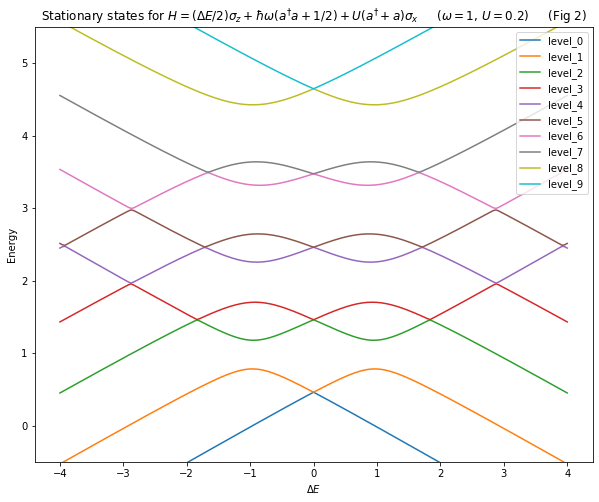

In [10]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=True, 
        title=f"Stationary states for {H_latex}     ($\omega=1$, $U=0.2$)     (Fig 2)");
plt.ylabel("Energy");

There are many things to say about what we see in Fig 2.

Two main features are:
1. the splitting of the levels increases with increasing level number i.e increasing number of bosons. 
2. not all crossings have been split apart into anti-crossings as we expected - this means some levels don't interact with each other at all. 

On 1. Applying our knowledge from Tutorial 1, we would say that the effective coupling between levels (which is proportional to the level splitting) increases with increasing boson number.

On 2. Upon closer inspection, what can be seen is that when $\Delta E  \approx 2 \omega, 4 \omega ...$ etc. the levels still cross, i.e. there is no interaction between them. It is not obvious at this scale but, when we zoom in, we will find that not only do we have an anti-crossing when $\Delta E \approx \omega$ (the most pronounced in Fig 2) but also when $\Delta E  \approx 3 \omega, 5\omega...$ etc (we'll come to why we now use $\approx$ instead of = shortly). This tells us that our prediction of other resonances was only correct for the odd integer ones - we will understand why soon. To see the anti-crossing more clearly for $\Delta E \approx 3\omega$ we need to zoom in a bit.

To perform this zoom, it is best to perform a higher resolution scan of $\Delta E$:

In [11]:
df = make_df_for_energy_scan("$\Delta E$", 2.8, 2.95, 201, two_state.shape[0])

for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

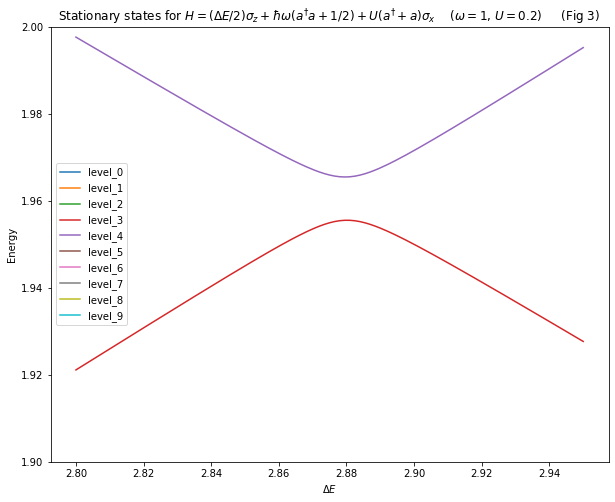

In [12]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[1.9,2],legend=True, 
        title=f"Stationary states for {H_latex}    ($\omega=1$, $U=0.2$)     (Fig 3)");
plt.ylabel("Energy");



The level splitting seen in Fig 3 is much smaller than those seen in Fig 2 when $\Delta E \approx \omega$ - i.e. the effective coupling between levels at this resonance is much less. This gives some physical meaning to our earlier description of these other resonances as "non-primary".

Fig 3 also shows us that the location of the resonance is somewhat shifted, i.e. the anti-crossing does not occur when $\Delta E = 3 \omega$ but instead $\Delta E \approx 3\omega$. This shift is known as the [Bloch-Siegert shift](https://en.wikipedia.org/wiki/Bloch-Siegert_shift) (see also [Cohen-Tannoudji](https://iopscience.iop.org/article/10.1088/0022-3700/6/8/007) and [Hagelstein](https://iopscience.iop.org/article/10.1088/0953-4075/41/3/035601)) and arises from the the effect of the interaction energy in the Hamiltonian ($E_{I}$). Specifically, the resonance condition should instead be written as $\Delta E + E_{I} = 3\omega$ and hence the value of $\Delta E$ needed for resonance is somewhat reduced. 

We can see the splitting of the levels and shifting of the resonances more clearly by scanning through various values of the interaction strength $U$. Let's create an [animated gif](https://github.com/maxhumber/gif) to show this.

In [13]:
# NOTE: THIS CELL TAKES ABOUT 2 MIN TO RUN

dfs = []                        # This will hold the dataframes for each value of U
Us = np.linspace(0, 0.6, 40)    # This will give us 40 frames in our animation from U=0 to U=0.6

for U in Us:
    
    df = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state.shape[0])

    for i, row in df.iterrows():
        H =  row["$\Delta E$"]*two_state + 1*bosons + U*interaction
        evals, ekets = H.eigenstates()
        df.iloc[i,1:] = evals 
        
    dfs.append(df)

In [14]:
# Uses the gif library from https://github.com/maxhumber/gif
@gif.frame
def plot(df,j):
    df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=True, 
        title=f"Stationary states for {H_latex}     ($\omega=1$, $U={Us[j]:.3f}$) ");
    plt.ylabel("Energy");
    
    
frames = []
for j, df in enumerate(dfs):
    frame = plot(df, j)
    frames.append(frame)
gif.save(frames, "./img/04-energy-levels.gif", duration=250)

In [15]:
# We need to rename the .gif to .gif.png so that the animation will render on GitHub and also NbViewer.
# The Gif library does not allow us to name the file with .gif.png
os.rename("./img/04-energy-levels.gif", "./img/04-energy-levels.gif.png")

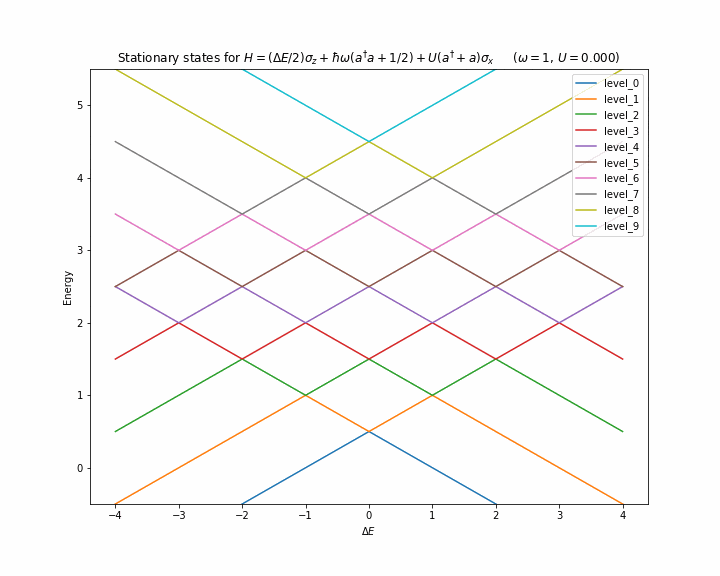

In [17]:
Image(filename="./img/04-energy-levels.gif.png")

Fig 3 also suggests some new physics. A resonance at $\Delta E \approx 3\omega$ implies that it might be possible for the TSS transition from |+> to |-> to result in the emission of 3 smaller bosons instead of a single larger one (as we would normally expect) - so called "down conversion". We'll investigate this possibility shortly.

In the meantime, let's try and understand why some levels don't couple to each other.

## 4.3 - Structure of the Hamiltonian

We have seen in Fig 2 that some energy levels don't interact with each other - why?

To answer this question we need to visualise the Hamiltonian. QuTiP offers a function called [`hinton`](http://qutip.org/docs/latest/apidoc/functions.html?highlight=hinton#qutip.visualization.hinton) for just such a purpose.

We'll use a Hamiltonian with a very large coupling of $U=1$ so that we'll be able to see things more clearly.

In [7]:
H = 1*two_state + 1*bosons + 1*interaction

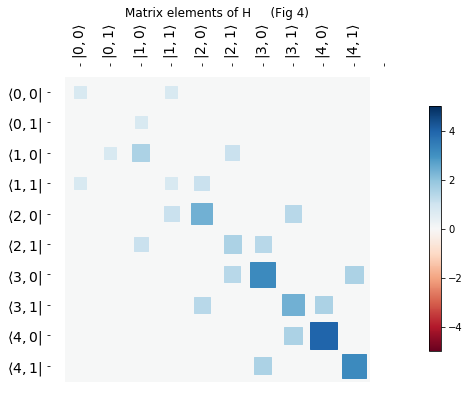

In [8]:
f, ax = hinton(H)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 4)");

The colour and size of the squares in Fig 4 give you a measure of the how large various matrix elements are. The off diagonal elements arise solely from the interaction part of the Hamiltonian - this is what allows one state to (in a sense) "mutate" into another.


**Important detour on state numbers and labels**

We'll study Fig 4 in more detail shortly, but for now I want to draw your attention to the labels for the rows and columns. For example:
- $|3, 0 \rangle$ represents 3 bosons and a TSS state of |+>
- $|3, 1 \rangle$ represents 3 bosons and a TSS state of |->

It is hard to remember QuTiP's convention for the numbering of states. It is therefore very helpful to have a way to map these QuTiP number states to something more immediately recognisable - let's create such a map.

In [9]:
possible_ns = range(0, max_bosons+1)
possible_ms = ["+","-"]
nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]

In [10]:
nm_list

[(0, '+'),
 (0, '-'),
 (1, '+'),
 (1, '-'),
 (2, '+'),
 (2, '-'),
 (3, '+'),
 (3, '-'),
 (4, '+'),
 (4, '-')]

Whenever we want to know what |n,±> state corresponds to QuTiP's number state e.g. 4, we can just do this:

In [11]:
nm_list[4]

(2, '+')

We can create some nice labels corresponding to the `nm_list`. This will make things plots easier to understand.

In [12]:
def make_braket_labels(nm_list):
    bra_labels = ["$\langle$"+str(n)+", "+str(m)+" |" for (n,m) in nm_list]
    ket_labels = ["| "+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in nm_list]
    return bra_labels, ket_labels

In [13]:
bra_labels, ket_labels = make_braket_labels(nm_list)

We can now pass these labels into the Hinton diagram

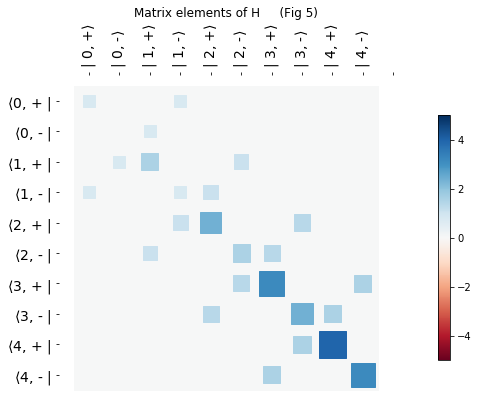

In [14]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 5)");

That's better!

If we now take a closer look at the structure of the Hinton diagram we can see some interesting features when we follow a path that connects one state to another. 

How are the states connected? In other words - how do we move across the Hinton diagram? In short, we can only move horizontally and vertically. In more detail:
1. Pick a starting state from the list on the x-axis $|\psi>$
2. Move vertically down the Hinton diagram until you reach the diagonal - this matrix element, $<\psi|H|\psi>$, represents the energy of the system when it's in the $|\psi>$ state
3. Move horizontally until you meet a coloured square - this matrix element, $<\psi|H|\phi>$,  represents the interaction energy between $|\psi>$  and $|\phi>$
4. Repeat step 2

Let's look at an example:

                Matrix elements of H     (Fig 6)


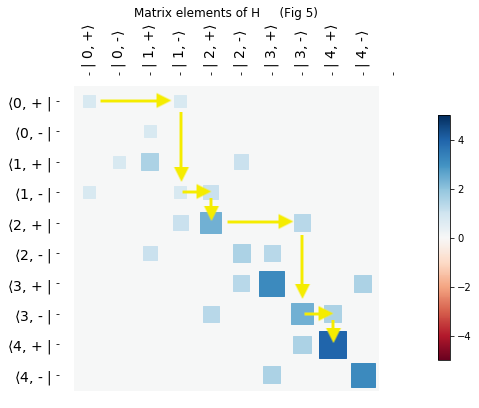

In [27]:
print("                Matrix elements of H     (Fig 6)")
Image(filename='./img/04-hinton.png') 

If we imagine starting a simulation with 0 bosons and the TSS in its + state, i.e. |0,+>, then Fig 6 suggests that:
1. there are connections (albeit indirect) from |0,+> to many different states with many more bosons, e.g. $|0,+> \rightarrow |1,-> \rightarrow |2,+> \rightarrow |3,-> \rightarrow |4,+> ...$
2. there are some states that are not accessible at all if we start in the |0,+> state

On 1. These indirect connections provide a mechanism to achieve the potential down conversion that we saw hints of earlier (namely $|0,+> \rightarrow |3,->$).

On 2. The Hamiltonian appears to be composed of two separate "universes" that don't interact with each other. In our energy level diagram (Fig 2) both universes are present - perhaps if we separate them we'll only see anti-crossings in the respective plots.

We're getting closer to convincing ourselves of the reality of down conversion, but before we check this through simulation we need to figure out how to separate the two universes.

## 4.4 - Parity

What separates the two spin-boson universes is a form of [parity](https://en.wikipedia.org/wiki/Parity_%28physics%29). Parity is not particularly intuitive and a full discussion of it is somewhat involved and takes us deep into the topic of transition [selection rules](https://en.wikipedia.org/wiki/Selection_rule) - we'll come back to this another time.

For now, the important thing to note is [how the parity operator $P$ acts on the spin-boson system](https://iopscience.iop.org/article/10.1088/0305-4470/29/14/026):
- for the TSS, $P |\pm> = \pm1|\pm> $, i.e. parity operator is the same as $\sigma_z$
- for [the field](https://ia801608.us.archive.org/11/items/TheParityOperatorForTheQuantumHarmonicOscillator/partity_article.pdf) with $n$ bosons, $P |n> = -1^n |n>$, i.e. the parity is $-1^n = e^{i\pi n}$ 

The combined parity is made by multiplying the two together and we can do this easily in QuTiP by using the [`expm`](http://qutip.org/docs/latest/apidoc/classes.html#qutip.Qobj.expm) function to create the exponential operator from the number operator $n = a^{\dagger}a$.  Let's see this in action:

In [15]:
sz = 2*two_state                 # recall that we set Delta_E=1 for this example, so two_state = 1/2*s_z
P = sz*(1j*np.pi*number).expm()

Creating a hinton diagram for the parity operator is revealing:

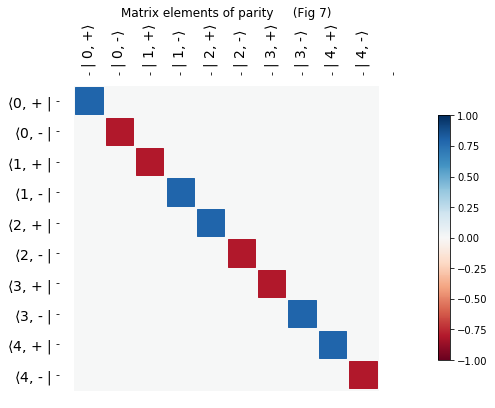

In [16]:
f, ax = hinton(P, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of parity     (Fig 7)");

In Fig 7, we see that the the blue squares (parity=+1, often called even) matches up with the path of the yellow arrows in Fig 6 (along the diagonal). This suggests that if we start on a blue/red square then we remain on a blue/red square, i.e. parity is conserved during the evolution of the system.

To check this, we need to look at the [`commutator`](http://qutip.org/docs/latest/apidoc/functions.html#qutip.operators.commutator) between the Hamiltonian and parity:

In [30]:
commutator(H,P)

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

A [zero commutator with H](https://youtu.be/eZ2UKJqLs4M) tells us that parity is indeed conserved as the system evolves. We can therefore break up the description of our system into two universes based on whether the states have even (+1) parity or odd (-1) parity.

Before we automate the process of universe separation based on parity, let's manually take a look at even parity.

First, we need to get the row/column numbers where we have parity = 1

In [31]:
even = np.where(P.diag()==1)[0]
even

array([0, 3, 4, 7, 8])

We can now use a QuTiP function called [`extract_states`](http://qutip.org/docs/latest/apidoc/classes.html?highlight=extract_states#qutip.Qobj.extract_states) to only select the even parts of the Hamiltonian that interest us:

In [32]:
H_even = H.extract_states(even)

Before we have a look at the resulting Hinton diagram we must also extract the corresponding state list |n,±>:

In [33]:
nm_list_even = [nm_list[i] for i in even]
nm_list_even

[(0, '+'), (1, '-'), (2, '+'), (3, '-'), (4, '+')]

We must also remember to re-generate our labels

In [34]:
bra_labels, ket_labels = make_braket_labels(nm_list_even)

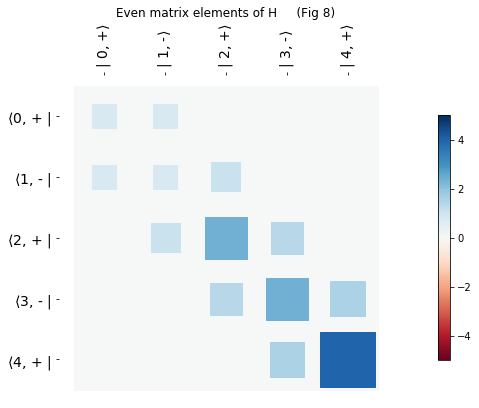

In [35]:
f, ax = hinton(H_even, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Even matrix elements of H     (Fig 8)");

Now with only a single parity, Fig 8 makes it easier to see how the system behaves - boson numbers can only change by one each time and when they do, the TSS must flip between |+> and |-> (the same is true for the odd universe).

Now, we'll automate the parity extraction process. Let's augment the `make_operators` function to do this:

In [4]:
def make_operators(max_bosons, parity=0):
    
    a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
    sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
    sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator
    
    two_state     =  1/2*sz                         # two state system energy operator   𝜎𝑧/2
    bosons       =  (a.dag()*a+0.5)                 # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                       # boson number operator              𝑎†𝑎
    interaction  = (a.dag() + a) * sx               # interaction energy operator        (𝑎†+𝑎)𝜎𝑥  
    
    P = sz*(1j*np.pi*a.dag()*a).expm()              # parity operator 
    
    # map from QuTiP number states to |n,±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state   = two_state.extract_states(p)
        bosons      = bosons.extract_states(p)
        number      = number.extract_states(p)
        interaction = interaction.extract_states(p)
        nm_list     = [nm_list[i] for i in p]
    
    
    return two_state, bosons, interaction, number, nm_list

We are now in a position to compare the energy level plots for the different parity universes side by side.

In [37]:
# ODD PARITY

two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=4, parity=-1)

df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state.shape[0])

for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [9]:
# EVEN PARITY

two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=4, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

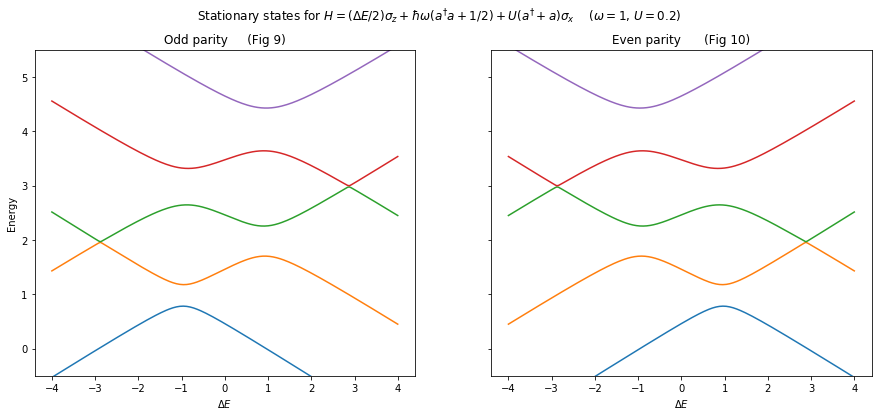

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)

fig.suptitle(f"Stationary states for {H_latex}    ($\omega=1$, $U=0.2$)")

df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd parity     (Fig 9)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even parity      (Fig 10)",  ax=axes[1]);

axes[0].set_ylabel("Energy");


Figs 9 and 10 show us the energy of the stationary states for the odd and even parity states respectively. As we expected, all levels now anti-cross when they approach each other because in each universe there are no forbidden interactions.

We can now see that the appearance of resonances in Fig 1 at $\Delta E = 2\omega, 4\omega$ etc was in a sense an illusion and that only the odd resonances $\Delta E = \omega, 3\omega, 5\omega$ are physical.

Good news - with separate parity universes, we can run all simulations much faster because we can remove half the states from consideration 🙌. This includes, of course, simulating the anti-crossing that inspired the down conversion ideas in Fig 3. Let's get to it!

## 4.5 - Down conversion

We've seen several signs that when $\Delta E \approx 3\omega$ (anti-crossing in Fig 10 and also Fig 3) we can expect down conversion, i.e. $|0,+> \rightarrow |3,->$. Let's simulate and see if we are correct.

The last energy level diagram we created was Fig 10 for even parity. Let's see if |0,+> is part of this universe.

In [10]:
nm_list

[(0, '+'), (1, '-'), (2, '+'), (3, '-'), (4, '+')]

We can see that indeed |0,+> is the 0th state in this universe. We can therefore set up our initial state for the simulation $\psi_0$ using the `basis` function we have used before in the following way:

In [11]:
psi0 = basis(len(nm_list), 0)
psi0

Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]]

To create the Hamiltonian corresponding to the anti-crossing we saw in Fig 3 we just need to choose the value of $\Delta E$ - by eye this is about 2.88.

In [12]:
H =  2.88*two_state + 1*bosons + 0.2*interaction

In previous tutorials we have been using QuTiP's [`sesolve`](http://qutip.org/docs/latest/apidoc/functions.html#module-qutip.sesolve) to solve the Schrödinger equation. This was convenient for us when we were getting started - we only needed a single line of code to run the simulation. It was especially useful when we introduced a time dependent perturbation to our TSS Hamiltonian in [Tutorial 2](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#2.2-Time-dependent-perturbation). However, `sesolve` will cause us problems as we increase the number of bosons that we want to simulate - the simulation will take too long to run.

Technically, we don't actually need a special solver like `sesolve` when dealing with time-independent problems (like ours). The business of solving the Schrödinger equation can be reduced to a problem of finding the eigenvalues and eigenvectors of the Hamiltonian.

We'll not go into the details of how this works right now - head over to the appendix for that. For now, we'll just use the results to run some simulations.

In [13]:
def simulate(H, psi0, times):
    num_states = H.shape[0]
    
    # create placeholder for values of amplitudes for different states
    psi = np.zeros([num_states,times.size], dtype="complex128")
     # create placeholder for values of occupation probabilities for different states
    P = np.zeros([num_states,times.size], dtype="complex128")
    
    evals, ekets = H.eigenstates()
    psi0_in_H_basis = psi0.transform(ekets)

    for k in range(0,num_states):
        amp = 0
        for i in range(0,num_states):
            amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
        psi[k,:] = amp
        P[k,:] = amp*np.conj(amp)
    return P, psi

In [14]:
times = np.linspace(0.0, 1000.0, 1000)
P, psi = simulate(H, psi0, times)

Before we make the plots, we must remember to regenerate the state labels.

In [15]:
bra_labels, ket_labels = make_braket_labels(nm_list)

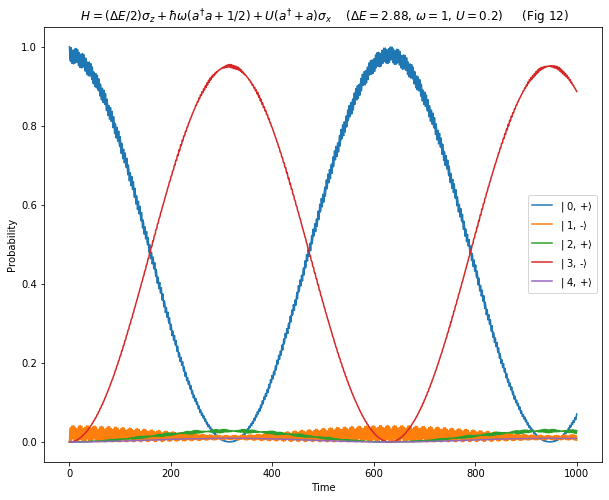

In [16]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f" {H_latex}    ($\Delta E=2.88$, $\omega=1$, $U=0.2$)     (Fig 12)")
plt.show();

Fig 12 shows us that our ideas were correct - the system starts off with no bosons and, over time, transitions to a state with 3 bosons at the expense of the TSS energy. We can see this energy exchange explicitly by evaluating the expectation values of the various parts of the Hamiltonian.

QuTiP does allow us to do this using the [`expect`](http://qutip.org/docs/latest/guide/guide-states.html#expectation-values) function. However, it turns out that we need to create a `Qobj` for every time step in order to use this function and that can be very slow. We will instead directly calculate the expectation value using matrix multiplication, i.e.


$<H> = \psi^{\dagger}H\psi = \psi^{\dagger} @ (H @\psi) $

Where @ is the matrix multiplication operator and $\dagger$ in this context means taking the complex conjugate.

Let's automate this process for all time steps using a function.

In [17]:
def expectation(operator, states):
    operator_expect = []
    for i in range(0,shape(states)[1]):
        e = np.conj(states[:,i])@ (operator @ states[:,i])
        operator_expect.append(e)
    return operator_expect

We can now see how the different parts of the Hamiltonian change over time:

In [18]:
hamiltonian_expect = expectation(H,psi)
two_state_expect = expectation(2.88*two_state,psi)
bosons_expect = expectation(1*bosons,psi)
interaction_expect = expectation(0.2*interaction,psi)

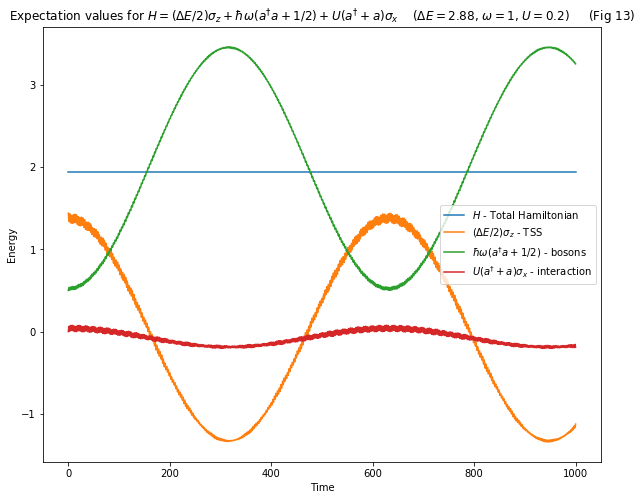

In [29]:
plt.figure(figsize=(10,8))
plt.plot(times, hamiltonian_expect, label="$H$ - Total Hamiltonian")
plt.plot(times, two_state_expect, label="$(\Delta E/2) \sigma_z$ - TSS")
plt.plot(times, bosons_expect, label="$\hbar\omega(a^{{\dagger}}a +1/2)$ - bosons")
plt.plot(times, interaction_expect, label="$U( a^{{\dagger}} + a )\sigma_x$ - interaction")

plt.ylabel("Energy")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"Expectation values for {H_latex}    ($\Delta E=2.88$, $\omega=1$, $U=0.2$)     (Fig 13)")
plt.show();

In Fig 13 we can indeed see the energy exchange that we expect between the TSS and the boson field. We can also see how the interaction energy is moving in sync with the two state energy - in some sense augmenting it. Sometimes people refer to this behaviour as the field is "dressing" the levels of the TSS.

## Next up...

We've discovered the surprising new physics of down conversion by exploring the energy levels of the spin boson system. This is just the tip of the ice berg though. How strong do these resonances get as we increase the boson number? How sensitive are the resonances compared to each other? We'll explore that and more in future tutorials. Before we dig into those details, let's see what delights await us when we add another two state system into the mix.


---

## Appendix - Solving the Schrödinger equation

To illustrate how we solve the Schrödinger equation using the function `simulate`, we will go through an example using the set-up of down conversion in Section 4.5.

In [61]:
# Create the operators and state list for even parity universe
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=4, parity=1)

# Create the Hamiltonian corresponding to the anti-crossing we saw in Fig 3
H =  2.88*two_state + 1*bosons + 0.2*interaction

In [62]:
psi0 = basis(len(nm_list), 0)

We have said that
> the business of solving the Schrödinger equation can be reduced to a problem of finding the eigenvalues and eigenvectors of the Hamiltonian

What do we mean by this? Let's see how it works and then go through an example:

1. Transform initial state $\psi_0$ into a new basis defined by the eigenvectors (aka eigenkets) of the Hamiltonian i.e. the states of constant energy (represented here by $|i>$)
  - $\psi_0 = \underset{i}{\Sigma}   <i|\psi_0> |i>$
  -  $<i|\psi_0> = $ `psi0.transform(ekets)[i]`
2. Evolve each part of the state according to its eigenfrequency (aka eigenvalues) $\omega_i$
  - $\psi (t)= \underset{i}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ |i>$
  - $\omega_i =$ `evals[i]`
3. Transform the evolved state back into the basis we started with (represented here by $|k>$)
  - $\psi (t)= \underset{i,k}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ <k|i>|k>$
  - $<k|i> = $ `ekets[i][k]`

Let's try it out.

**Step 1**:

In [63]:
evals, ekets = H.eigenstates()
psi0_in_H_basis = psi0.transform(ekets)

In [64]:
psi0_in_H_basis

Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[-1.03242717e-01]
 [ 6.97302743e-01]
 [ 7.09269873e-01]
 [ 6.78758529e-03]
 [ 4.16601830e-05]]

This way of representing $\psi_0$ shows us that at the anti-crossing $|0,+>$ is mainly a mixture of the 1st and 2nd energy states. QuTiP has a convenient way of visualising the probabilities associated with such a state using [`plot_fock_distribution`](http://qutip.org/docs/latest/apidoc/functions.html?highlight=plot_fock_distribution#qutip.visualization.plot_fock_distribution)

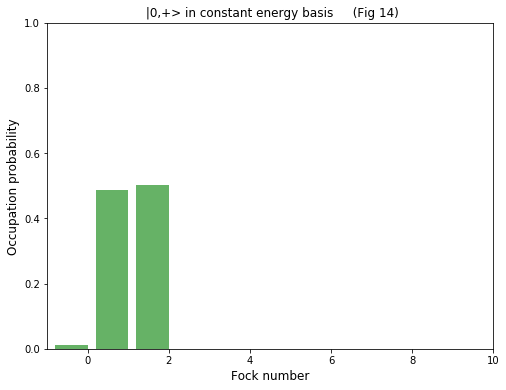

In [65]:
plot_fock_distribution(psi0_in_H_basis, title=f" |0,+> in constant energy basis     (Fig 14)")
plt.xlim(-1,10);

Continuing to follow the procedure, we have:

$\psi_0 = \underset{i}{\Sigma}  <i|\psi_0> |i> \\
\ \ \ \ = -0.103 |0> + 0.697 |1> + 0.709 |2> +...$

**Step 2:**

The frequencies are given by the eigenvalues of the Hamiltonian:

In [66]:
evals

array([0.01846842, 1.95554692, 1.96549683, 4.01906122, 5.98142661])

and so the evolved state becomes:

$\psi (t)= \underset{i}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ |i> \\
\ \ \ \ =  -0.103 e^{-i 0.018t}|0> + 0.697 e^{-i 1.96t}|1> +0.709 e^{-i 1.96t} |2> +...$

**Step 3:**

Taking only the $|1>$ part form step 2 above for the sake of brevity, we only need to look at `ekets[1]`

In [67]:
ekets[1]

Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[ 0.69730274]
 [ 0.05420454]
 [-0.1298011 ]
 [ 0.69932371]
 [-0.07020524]]

Then:

$0.697 e^{-i 1.96t}|1> \rightarrow 0.697 e^{-i 1.96t}0.697|0'> + 0.697 e^{-i 1.96t}0.054|1'> + 0.697 e^{-i 1.96t}(-0.130)|2'> + 0.697 e^{-i 1.96t}0.699|3'> +...$

where the prime in $|n'>$ indicates the original basis and not the energy basis. We can re-label these states to be the more familiar $|n,\pm>$ using the list we made earlier:

In [68]:
nm_list

[(0, '+'), (1, '-'), (2, '+'), (3, '-'), (4, '+')]

and so we have:

$0.697 e^{-i 1.96t}|1> \rightarrow 0.697 e^{-i 1.96t}0.697|0,+> + 0.697 e^{-i 1.96t}0.054|1,-> + 0.697 e^{-i 1.96t}(-0.130)|2,+> + 0.697 e^{-i 1.96t}0.699|3,-> +...$

All of the above can be automated by the function below. We have labeled the steps to hopefully make it easier to understand.

```python
def simulate(H, psi0, times):
    num_states = H.shape[0]
    
    psi = np.zeros([num_states,times.size], dtype="complex128")
    P = np.zeros([num_states,times.size], dtype="complex128")
    
    # STEP 1
    evals, ekets = H.eigenstates()
    psi0_in_H_basis = psi0.transform(ekets)

    for k in range(0,num_states):
        amp = 0
        for i in range(0,num_states):
            #                                         STEP 2               STEP 3
            amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
        psi[k,:] = amp
        P[k,:] = amp*np.conj(amp)
    return P, psi
```